In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from functools import reduce # for merging dataframes
import sqlite3
import re
import os

In [2]:
def load_data():
    """
    This function connect to db, and save queried data to csv files
    """
    conn = sqlite3.connect('data/Database.db') 
    print('connected to db ')
          
    sql_query1 = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM coilDataInput
                               ''', conn)
    sql_query2 = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM B3_table
                               ''', conn)
    sql_query3 = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM B4_table
                               ''', conn)
    sql_query4 = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM B5_table
                               ''', conn)

    print('query_started')
    main_df = pd.DataFrame(sql_query1, columns = ['coil', 'furnace Number', 'analyse', 'Hardness_1', 'Hardness_2',
       'Width', 'Temperature before finishing mill',
       'Temperature after finishing mill', 'Thickness', 'Thickness profile',
       'C', 'Mn', 'Si', 'Nb', 'P', 'S', 'Al', 'M_Al', 'B', 'N', 'Ti', 'Cr',
       'V', 'Mo'])

    B3_df =pd.DataFrame(sql_query2, columns = ['coilId', 'lengthCoordinate', 'B3'])
    B4_df =pd.DataFrame(sql_query3, columns = ['coilId', 'lengthCoordinate', 'B4'])
    B5_df =pd.DataFrame(sql_query4, columns = ['coilId', 'lengthCoordinate', 'B5'])

    B3_df.rename(columns = {'coilId':'coil', 'lengthCoordinate':'length', 'B3':'width_B3'}, inplace = True)
    B4_df.rename(columns = {'coilId':'coil', 'lengthCoordinate':'length', 'B4':'width_B4'}, inplace = True)
    B5_df.rename(columns = {'coilId':'coil', 'lengthCoordinate':'length', 'B5':'width_B5'}, inplace = True)
    
    B3_df.to_csv('data/csv_data/B3.csv', index = False, header = True) # save df into csv file
    B4_df.to_csv('data/csv_data/B4.csv', index = False, header = True)
    B5_df.to_csv('data/csv_data/B5.csv', index = False, header = True)
    main_df.to_csv('data/csv_data/coilData.csv', index = False, header = True )
    print('finished saving the csv files')



In [3]:
def visualize_measurments(measurement_df, name, constriction, count):
    """
     This functions makes plot for each coil Id

    """

    constriction_dir ='images/constriction/'
    not_constriction_dir = 'images/not_constriction/'
    
    x_upper_limit = measurement_df['length'].max() - 10
    measurement_df=measurement_df[(measurement_df.length >=100) &(measurement_df.length <= x_upper_limit -10)]
    y_lower_limit, y_higher_limit = measurement_df[['width_B3', 'width_B4','width_B5']].min().min().min(), measurement_df[['width_B3', 'width_B4','width_B5']].max().max().max()
    
    fig, ax = plt.subplots(figsize=(16,6))
    ax.plot(measurement_df['length'], measurement_df['width_B3'], color = 'b', label = 'B3', linewidth = 0.75)
    ax.plot(measurement_df['length'], measurement_df['width_B4'], color = 'r', label = 'B4', linewidth = 0.75)
    ax.plot(measurement_df['length'], measurement_df['width_B5'], color = 'g', label = 'B5', linewidth = 0.75)
    ax.legend(loc="upper right")

    
    ax.set(xlabel='length in meters', ylabel='width in millimeters',title= name)
    ax.set_ylim(y_lower_limit -1, y_higher_limit + 1) # limit plot dynamically according the data
    ax.set_xlim(100,x_upper_limit)
    ax.set_xticks([120,190], minor=True)
    ax.xaxis.grid(True, which='minor')
    
    
    if constriction == 0: # saves images with constriction and not constriction in seperate folder
        fig.savefig(not_constriction_dir + str(name) +'.png', dpi = 100)
    else:
        fig.savefig(constriction_dir + str(name) + '.png', dpi = 100) 

    
    if count <= 5: # show plot only for the first 5 coils
        plt.show()
    else:
        plt.close()

    

In [4]:
def set_constriction():
    """ 
    This function determine whether a coil is constricted or not based on B3,B4,B5 measurement
    It adds a new column "Is_constriction" to the main data frame
    
    """
    #load_data()
    print('starting loading csv files')
    B3_df = pd.read_csv('data/csv_data/B3.csv')
    B4_df = pd.read_csv('data/csv_data/B4.csv')
    B5_df = pd.read_csv('data/csv_data/B5.csv')
    main_df = pd.read_csv('data/csv_data/CoilData.csv')

    coil_label_list = []   # keeps coil Id , Is_constriction(0|1),constriction_width
    
    missing_file_error = [] # keeps coil Id , with either B3,B4,B5 file is missing
    missing_data_error = [] # keeps coil Id,  with either B3.B4,B5 has missing data
    unclassified_error = [] # keeps coil Id , with unknown error

    count = 0  # track the number of coils
    main_index = main_df[(main_df['coil'] <= 283800)].index # remove some rows
    main_df.drop(main_index, inplace = True)
    print('started determining constriction')
    main_copy_df = main_df.copy()
    for index, row in main_df['coil'].items():
        
        try:
            print(f'row: {row} index: {index}')
            
            if((row not in B3_df.values)|(row not in B4_df.values)|(row not in B5_df.values)):
                missing_file_error.append(row)
                continue

            B3_row_df = B3_df[B3_df['coil']== row][['length','width_B3']]
            B4_row_df = B4_df[B4_df['coil']== row][['length','width_B4']]
            B5_row_df = B5_df[B5_df['coil']== row][['length','width_B5']]

            if((B3_row_df.empty)|(B4_row_df.empty)|(B5_row_df.empty)):
                missing_data_error.append(row)
                continue

            B3_index = B3_row_df[(B3_row_df['length'] <= 50)|(B3_row_df['length'] >= 300)|(B3_row_df['width_B3'] == 0)].index
            B4_index = B4_row_df[(B4_row_df['length'] <= 50)|(B4_row_df['length'] >= 300)|(B4_row_df['width_B4'] == 0)].index
            B5_index = B5_row_df[(B5_row_df['length'] <= 50)|(B5_row_df['length'] >= 300)|(B5_row_df['width_B5'] == 0)].index

            B3_row_df.drop(B3_index, inplace = True)
            B4_row_df.drop(B4_index, inplace = True)
            B5_row_df.drop(B5_index, inplace = True)

            B3_row_df['length'] = B3_row_df['length'].astype(int) # convert float value to int
            B4_row_df['length'] = B4_row_df['length'].astype(int)
            B5_row_df['length'] = B5_row_df['length'].astype(int)

            B3_grouped_row_df = B3_row_df.groupby('length', as_index=False)['width_B3'].mean(numeric_only =True)
            B4_grouped_row_df = B4_row_df.groupby('length', as_index=False)['width_B4'].mean(numeric_only =True)
            B5_grouped_row_df = B5_row_df.groupby('length', as_index=False)['width_B5'].mean(numeric_only =True)

            dfs = [B3_grouped_row_df, B4_grouped_row_df, B5_grouped_row_df]
            measurement_df = reduce(lambda  left,right: pd.merge(left,right,on=['length'],
                                            how='outer'), dfs)# merge all DataFrames into one
    
            targeted_measurement_df = measurement_df[(measurement_df.length >=120) &(measurement_df.length <= 190)].copy()
            targeted_measurement_df.loc[:, 'B3B4_mean_width'] = targeted_measurement_df.loc[:, ['width_B3','width_B4']].mean(1)
            targeted_measurement_df.loc[:, 'width_difference'] = targeted_measurement_df.loc[:, 'width_B5'] - targeted_measurement_df.loc[:, 'B3B4_mean_width']

            def constriction_status(value):
                if abs(value) <= 5:
                    return 0
                else:
                    return 1
            
            targeted_measurement_df.loc[:, 'Is_constriction'] = targeted_measurement_df.loc[:, 'width_difference'].map(constriction_status)
            constriction_width = len(targeted_measurement_df[targeted_measurement_df['Is_constriction']==1])

            if constriction_width >= 1:
                constriction = 1
            else:
                constriction = 0
            
            coil_label_list.append({'coil':row, 'Constriction_width':constriction_width, 'Is_constriction':constriction})
            count += 1 # increament number of coils processed
            if count <= 100:
                visualize_measurments(measurement_df,row, constriction, count) # visualize


        except:
            unclassified_error.append(row)
        if count == 11:
            break
        if (count == 10)|(count == 20)|(count == 1000)|(count == 5000)|(count == 10000)|(count ==15000)|(count == 20000):
            label_df = pd.DataFrame(coil_label_list)
            main_labeled_df = pd.merge(main_copy_df,label_df, on ='coil')
            main_labeled_df.to_csv('data/csv_data/output.csv', index = False, header = True )
            
            
    label_df = pd.DataFrame(coil_label_list)
    main_labeled_df = pd.merge(main_df,label_df, on ='coil')
    
    print(f'{len(missing_file_error)} coils have either B3,B4 B5 file missing : ', missing_file_error)
    print(f'{len(missing_data_error)} coils have either B3,B4 B5 file  empty: ', missing_data_error)
    print(f'{len(unclassified_error)} coils have unclassified error : ', unclassified_error)


    return main_labeled_df,coil_label_list
    
    
       

starting loading csv files
started determining constriction
row: 283801 index: 147


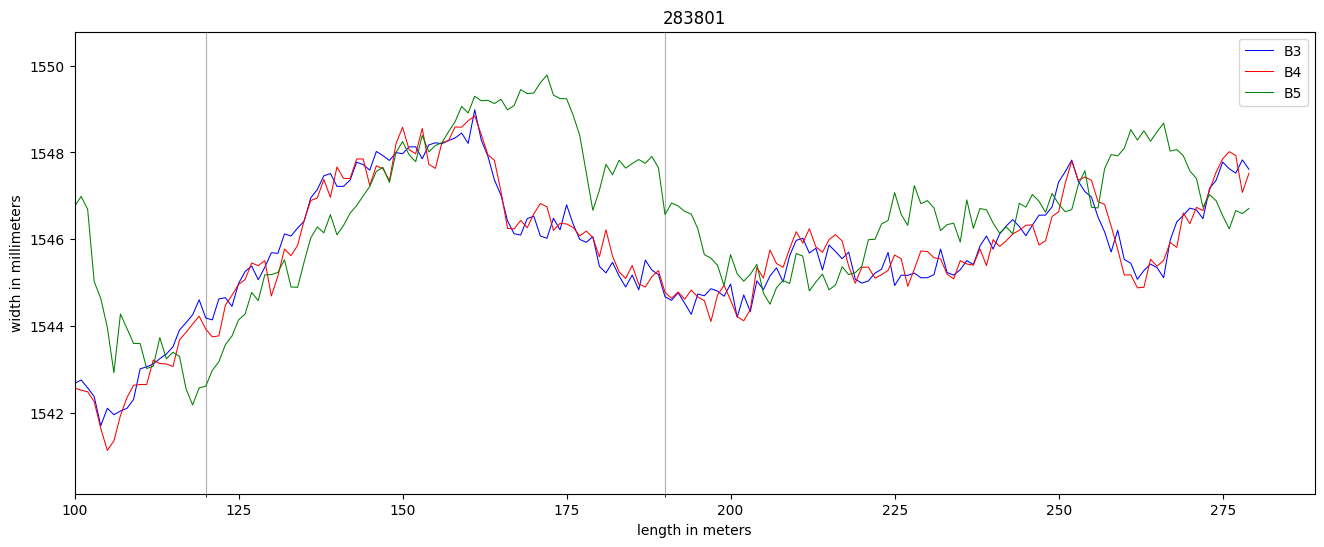

row: 283802 index: 148


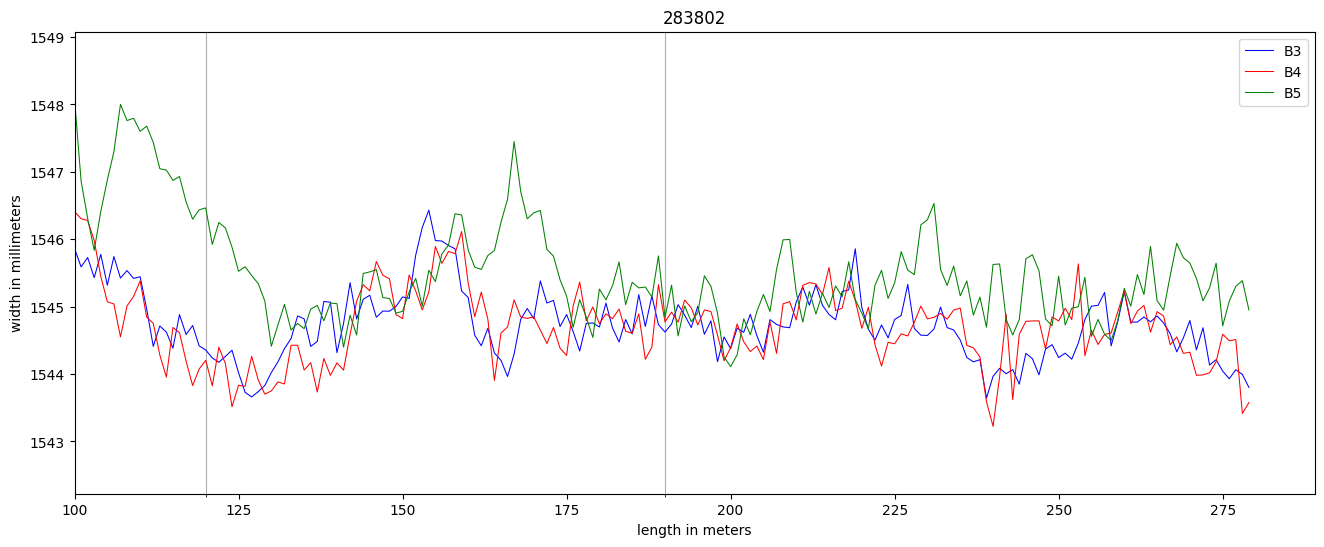

row: 283803 index: 149


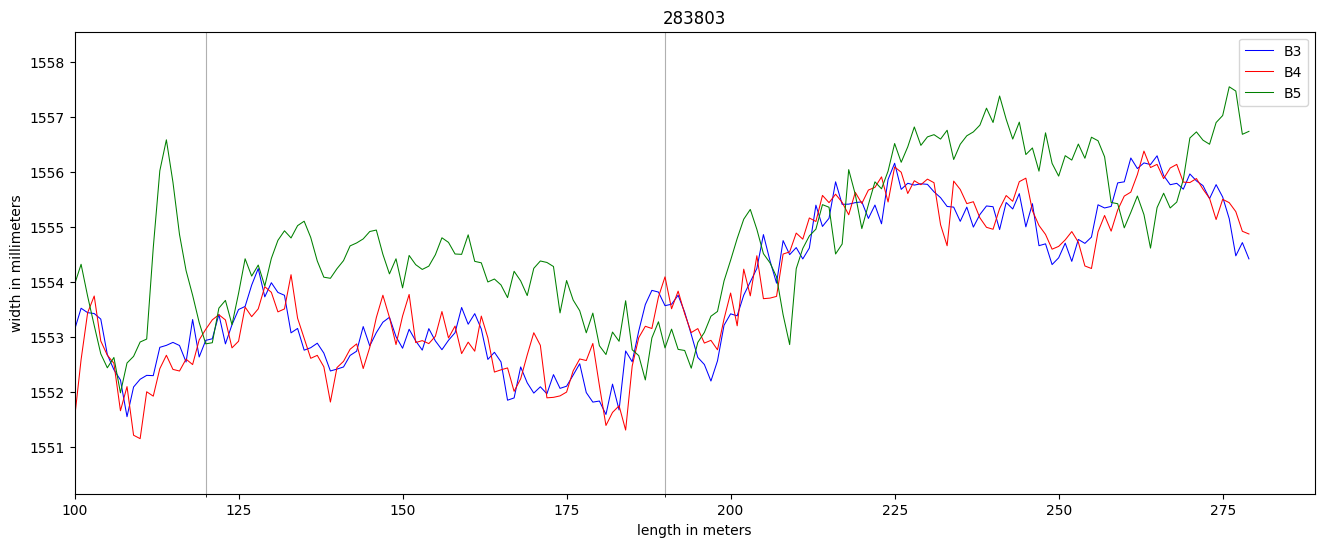

row: 283804 index: 150


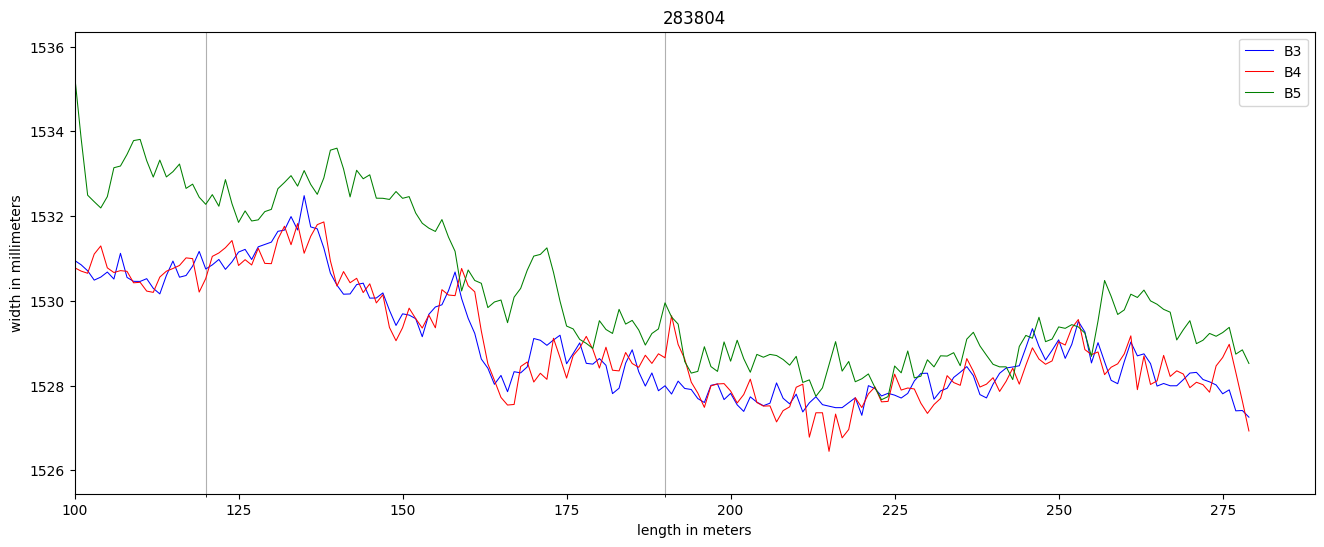

row: 283805 index: 151


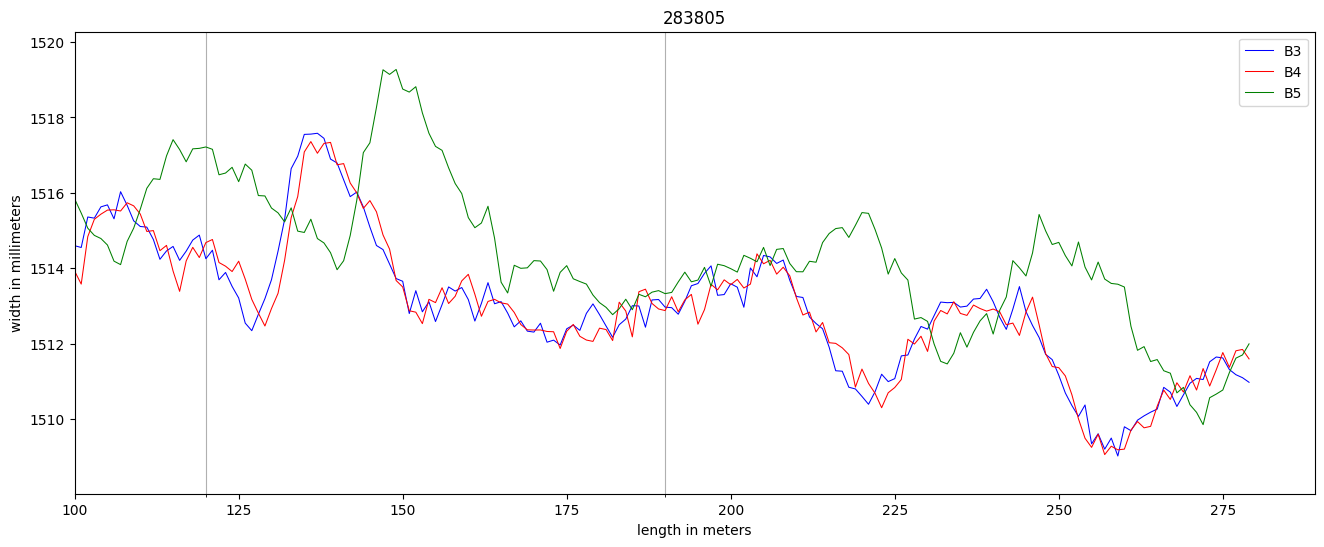

row: 283806 index: 152
row: 283807 index: 153
row: 283808 index: 154
row: 283809 index: 155
row: 283810 index: 156
row: 283811 index: 157
0 coils have either B3,B4 B5 file missing :  []
0 coils have either B3,B4 B5 file  empty:  []
0 coils have unclassified error :  []


In [5]:
def save_file():
    """
     saves the labeled dataframe with is_constriction column to csv file
    """
    df, label = set_constriction()
    df.to_csv('data/csv_data/output.csv', index = False, header = True )

save_file()


In [12]:
label_df = pd.DataFrame(label)
label_df.head()

,coil,Constriction_width,Is_constriction
0,283801,0,0
1,283802,0,0
2,283803,0,0
3,283804,0,0
4,283805,5,1


In [16]:

main_df = pd.read_csv('data/csv_data/CoilData.csv')
df = pd.merge(main_df, label_df, on = 'coil')
df.shape

(25111, 26)

In [18]:
df.to_csv('data/csv_data/output_final.csv', index = False, header = True )